In [ ]:
import pandas as pd
import pyspark

import seaborn  as sns
import matplotlib.pyplot as plt
%matplotlib inline

from pyspark.sql.functions import avg, stddev
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, \
                                        RandomForestClassifier

from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from sklearn.metrics import roc_curve, auc

In [39]:
sc = pyspark.SparkContext.getOrCreate()

In [40]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [41]:
sql_sc = pyspark.SQLContext(sc)

#### IMPORT TITANIC DATASET

In [43]:
titanic_ddf = (sql_sc
              .read
              .option('sep', ',')
              .option('header', 'true')
              .option('inferSchema', 'true')
              .csv('titanic_train.csv')
              )

In [44]:
titanic_ddf.printSchema(), titanic_ddf.count()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



(None, 891)

In [45]:
titanic_ddf.show(3)

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| null|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| null|       S|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
only showing top 3 rows



In [46]:
titanic_ddf.describe().toPandas().set_index('summary').transpose()

summary,count,mean,stddev,min,max
PassengerId,891,446.0,257.3538420152301,1,891
Survived,891,0.3838383838383838,0.48659245426485753,0,1
Pclass,891,2.308641975308642,0.8360712409770491,1,3
Name,891,None,None,"""Andersson, Mr. August Edvard (""""Wennerstrom"""")""","van Melkebeke, Mr. Philemon"
Sex,891,None,None,female,male
Age,714,29.69911764705882,14.526497332334035,0.42,80.0
SibSp,891,0.5230078563411896,1.1027434322934315,0,8
Parch,891,0.38159371492704824,0.8060572211299488,0,6
Ticket,891,260318.54916792738,471609.26868834975,110152,WE/P 5735
Fare,891,32.2042079685746,49.69342859718089,0.0,512.3292


In [47]:
titanic_ddf.dropna(subset=['Age', 'Embarked']).count()

712

In [48]:
titanic_ddf.agg(avg('Age'), stddev('Age')).first()

Row(avg(Age)=29.69911764705882, stddev_samp(Age)=14.526497332334035)

In [49]:
mean_age = titanic_ddf.agg({'Age':'avg'}).first()['avg(Age)']
mean_age

29.69911764705882

In [50]:
mode_embarked=titanic_ddf.groupBy('Embarked').count().orderBy('count', ascending=False).first()['Embarked']

In [51]:
prepared_ddf=titanic_ddf.fillna({'Age':mean_age, 'Embarked':mode_embarked})
prepared_ddf.describe().toPandas().set_index('summary').transpose()

summary,count,mean,stddev,min,max
PassengerId,891,446.0,257.3538420152301,1,891
Survived,891,0.3838383838383838,0.48659245426485753,0,1
Pclass,891,2.308641975308642,0.8360712409770491,1,3
Name,891,None,None,"""Andersson, Mr. August Edvard (""""Wennerstrom"""")""","van Melkebeke, Mr. Philemon"
Sex,891,None,None,female,male
Age,891,29.699117647058763,13.002015226002891,0.42,80.0
SibSp,891,0.5230078563411896,1.1027434322934315,0,8
Parch,891,0.38159371492704824,0.8060572211299488,0,6
Ticket,891,260318.54916792738,471609.26868834975,110152,WE/P 5735
Fare,891,32.2042079685746,49.69342859718089,0.0,512.3292


# PIPELINE

In [52]:
nsex=StringIndexer(inputCol='Sex', outputCol='nsex')
nembarked=StringIndexer(inputCol='Embarked', outputCol='nembarked')
oheembarked=OneHotEncoder(inputCol='nembarked',outputCol='vembarked', dropLast=False)

features = VectorAssembler(inputCols=['Pclass', 'nsex', 'Age', 'SibSp', 'Parch', 'Fare', 'vembarked'],
                         outputCol='features')
lr = LogisticRegression(labelCol='Survived')

In [53]:
pipeline = Pipeline(stages=[nsex, nembarked, oheembarked, features, lr])

In [54]:
train_ddf, test_ddf = prepared_ddf.randomSplit([0.7,0.3])
assert train_ddf.count()+test_ddf.count()== prepared_ddf.count(), "Problème avec le tirage"

In [55]:
model = pipeline.fit(train_ddf)

In [56]:
print(model.stages[-2].explainParams())

inputCols: input column names. (current: ['Pclass', 'nsex', 'Age', 'SibSp', 'Parch', 'Fare', 'vembarked'])
outputCol: output column name. (default: VectorAssembler_4ed5aa74a48aa4b13ff1__output, current: features)


In [57]:
model.stages[-1].intercept, model.stages[-1].coefficients

(0.4929433316518828,
 DenseVector([-1.2621, 2.9002, -0.0472, -0.3095, -0.1075, 0.0018, 2.0702, 2.5977, 2.4271]))

In [58]:
model.stages[-2].getParam('inputCols')

Param(parent='VectorAssembler_4ed5aa74a48aa4b13ff1', name='inputCols', doc='input column names.')

In [59]:
predictions = model.transform(test_ddf)

In [60]:
predictions.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = false)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = false)
 |-- nsex: double (nullable = true)
 |-- nembarked: double (nullable = true)
 |-- vembarked: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = true)



In [61]:
predictions.selectExpr('Survived', 'rawPrediction', 'probability', 'prediction').show(5)

+--------+--------------------+--------------------+----------+
|Survived|       rawPrediction|         probability|prediction|
+--------+--------------------+--------------------+----------+
|       1|[-2.7544580734868...|[0.05983536814706...|       1.0|
|       1|[-0.4634272287588...|[0.38617310551784...|       1.0|
|       1|[-2.3354831539984...|[0.08822658676276...|       1.0|
|       0|[2.25359806014292...|[0.90496044482324...|       0.0|
|       0|[2.31520580772565...|[0.91012857211821...|       0.0|
+--------+--------------------+--------------------+----------+
only showing top 5 rows



In [62]:
predictions[predictions['Survived'] == predictions['prediction']].count()/predictions.count()

0.7591240875912408

In [63]:
rf=RandomForestClassifier(labelCol='Survived')
pipeline_rf = Pipeline(stages=[nsex, nembarked, oheembarked, features, rf])

In [64]:
model_rf = pipeline_rf.fit(train_ddf)

In [65]:
predictions_rf = model_rf.transform(test_ddf)

In [66]:
predictions_rf[predictions_rf['Survived'] == predictions_rf['prediction']].count()/predictions_rf.count()

0.7883211678832117

In [67]:
predictions.crosstab('Survived', 'prediction').show()

+-------------------+---+---+
|Survived_prediction|0.0|1.0|
+-------------------+---+---+
|                  1| 37| 76|
|                  0|132| 29|
+-------------------+---+---+



In [68]:
evaluation = BinaryClassificationEvaluator(labelCol='Survived', rawPredictionCol='rawPrediction')
evaluation.getMetricName(), evaluation.evaluate(predictions)

('areaUnderROC', 0.8220194580333087)

In [69]:
evaluation.getMetricName(), evaluation.evaluate(predictions_rf)

('areaUnderROC', 0.816220524377508)

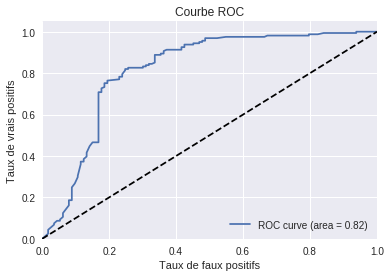

In [70]:
resultats = [(float(i[0][0]), 1.0-float(i[1])) for i in predictions_rf.select(['probability', 'Survived']).collect()]
 
fpr = dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in resultats]
y_score = [i[0] for i in resultats]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

In [71]:
#GridSearch on logistic regression
grid = ParamGridBuilder().addGrid(lr.maxIter, [50,100,200]).build()
crossvalidator = CrossValidator(estimator=pipeline,
                                estimatorParamMaps=grid,
                               evaluator=BinaryClassificationEvaluator(labelCol='Survived'),
                               numFolds=2)

In [72]:
cv_model = crossvalidator.fit(train_ddf)

In [73]:
cv_predictions = cv_model.transform(test_ddf)

In [74]:
evaluation.getMetricName(), evaluation.evaluate(cv_predictions)

('areaUnderROC', 0.8220194580333087)

In [76]:
#GridSearch on random forest
grid_rf = (ParamGridBuilder()
           .addGrid(rf.numTrees, [50,100])
           .addGrid(rf.maxDepth, [3, 5, 8]).build())

In [77]:
crossvalidator_rf = CrossValidator(estimator=pipeline_rf,
                                estimatorParamMaps=grid_rf,
                               evaluator=BinaryClassificationEvaluator(labelCol='Survived'),
                               numFolds=2)

In [78]:
cv_model_rf = crossvalidator_rf.fit(train_ddf)

In [79]:
cv_predictions_rf = cv_model_rf.transform(test_ddf)

In [80]:
evaluation.getMetricName(), evaluation.evaluate(cv_predictions_rf)

('areaUnderROC', 0.837300060462815)

In [2]:
##### FIN DU SCRIPT #####